In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import r2_score
%matplotlib inline
import seaborn as sns

pd.set_option("display.precision", 12)

In [ ]:
def score(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    print 'r2', r2, '\n'
    print 'abs(r2)**(1/2.0)', abs(r2)**(1/2.0), '\n'
    return np.sign(r2) * abs(r2)**(1/2.0)

In [2]:
with pd.HDFStore("train.h5", "r") as train:
    # Note that the "train" dataframe is the only dataframe in the file
    df = train.get("train")

In [ ]:
df['timestamp'].max()

In [ ]:
kfold = 5
time_length = df['timestamp'].max()/kfold

In [ ]:
time_length

In [ ]:
df.groupby('timestamp').id.nunique()

In [ ]:
df.groupby('timestamp').id.nunique().plot()

In [ ]:
temp = df.groupby('timestamp').id.nunique()
t2 = temp[-500:].copy()
t2

In [ ]:
t2.plot()

In [ ]:
t3 = np.ediff1d(t2)
t3

In [ ]:
t3.mean()


In [ ]:
t3.std()

In [ ]:
np.argwhere(t3>4)

In [ ]:
t4 = np.argwhere(np.ediff1d(temp)>4)
t4

In [ ]:
t4.size

In [ ]:
start_at = 1390

In [ ]:
cv = df.loc[df['timestamp'] >= start_at]

In [ ]:
cv.groupby('timestamp').id.nunique().size

In [ ]:
range(0,4)

In [ ]:
kfold = 4
time_interval = cv.groupby('timestamp').id.nunique().size/kfold
print 'time_interval =',time_interval
modulo = cv.groupby('timestamp').id.nunique().size % kfold
print 'modulo =',modulo
k = start_at
print 'k =',k
j = 0
X = []

for i in range(0,kfold):
    if (i == (kfold-1)) & (modulo>>0):
        j = (k + time_interval)
        print 'i =',i,',j =',j
        print 'j+modulo+1 = ',j+modulo+1
        X.append(cv.loc[(cv['timestamp'] < j+modulo+1) & (cv['timestamp'] >= k)])
        X[i]
        k = j
    else:
        j = (k + time_interval)
        print 'i =',i,',j =',j
        X.append(cv.loc[(cv['timestamp'] < j) & (cv['timestamp'] >= k)])
        X[i]
        k = j

In [ ]:
X[0]

In [ ]:
X[1]

In [ ]:
X[2]

In [ ]:
X[3]

In [ ]:
train = X[0]
test = X[1]

test_features = test.drop('y', axis=1)

test_target = test[['id', 'y']].copy()

excl = ['id', 'sample', 'y', 'timestamp']
cols = [c for c in train.columns if c not in excl]

roll_std = train.groupby('timestamp').y.mean().rolling(window=10).std().fillna(0)
train_idx = train.timestamp.isin(roll_std[roll_std < 0.009].index)

y_train = train['y'][train_idx]
xgmat_train = xgb.DMatrix(train.loc[train_idx, cols], 
                          label=y_train, 
                          feature_names=cols)

params_xgb = {'objective'        : 'reg:linear',
              'tree_method'      : 'hist',
              'grow_policy'      : 'depthwise',
              'eta'              : 0.05,
              'subsample'        : 0.6,
              'max_depth'        : 10,
              'min_child_weight' : y_train.size/2000,
              'colsample_bytree' : 1, 
              'base_score'       : y_train.mean(),
              'silent'           : True,
}

num_boost_round = 16

bst_lst = []
for i in range(8):
    params_xgb['seed'] = 623913 + 239467 * i
    bst_lst.append(xgb.train(params_xgb,
                             xgmat_train,
                             num_boost_round=num_boost_round,
                             verbose_eval=False).__copy__())

pr_lst = []

xgmat_test = xgb.DMatrix(test_features[cols])

for bst in bst_lst:
    pr_lst.append(bst.predict(xgmat_test))

pred = test_target.copy()

pred['y'] = np.array(pr_lst).mean(0)

print score(test_target['y'], pred['y'])

In [ ]:
train = X[0]
test = X[1]

test_features = test.drop('y', axis=1)

test_target = test[['id', 'y']].copy()

excl = ['id', 'sample', 'y', 'timestamp']
cols = [c for c in train.columns if c not in excl]

roll_std = train.groupby('timestamp').y.mean().rolling(window=10).std().fillna(0)
train_idx = train.timestamp.isin(roll_std[roll_std < 0.009].index)

y_train = train['y'][train_idx]
xgmat_train = xgb.DMatrix(train.loc[train_idx, cols], 
                          label=y_train, 
                          feature_names=cols)

params_xgb = {'objective'        : 'reg:linear',
              'tree_method'      : 'hist',
              'grow_policy'      : 'depthwise',
              'eta'              : 0.05,
              'subsample'        : 0.6,
              'max_depth'        : 5, # change 10 to 5
              'min_child_weight' : y_train.size/2000,
              'colsample_bytree' : 1, 
              'base_score'       : y_train.mean(),
              'silent'           : True,
}

num_boost_round = 16

bst_lst = []
for i in range(8):
    params_xgb['seed'] = 623913 + 239467 * i
    bst_lst.append(xgb.train(params_xgb,
                             xgmat_train,
                             num_boost_round=num_boost_round,
                             verbose_eval=False).__copy__())

pr_lst = []

xgmat_test = xgb.DMatrix(test_features[cols])

for bst in bst_lst:
    pr_lst.append(bst.predict(xgmat_test))

pred = test_target.copy()

pred['y'] = np.array(pr_lst).mean(0)

print score(test_target['y'], pred['y'])

In [ ]:
train = X[0]
test = X[1]

test_features = test.drop('y', axis=1)

test_target = test[['id', 'y']].copy()

excl = ['id', 'sample', 'y', 'timestamp']
cols = [c for c in train.columns if c not in excl]

roll_std = train.groupby('timestamp').y.mean().rolling(window=10).std().fillna(0)
train_idx = train.timestamp.isin(roll_std[roll_std < 0.009].index)

y_train = train['y'][train_idx]
xgmat_train = xgb.DMatrix(train.loc[train_idx, cols], 
                          label=y_train, 
                          feature_names=cols)

params_xgb = {'objective'        : 'reg:linear',
              'tree_method'      : 'hist',
              'grow_policy'      : 'depthwise',
              'eta'              : 0.05,
              'subsample'        : 0.6,
              'max_depth'        : 3, # change 10 to 3
              'min_child_weight' : y_train.size/2000, 
              'colsample_bytree' : 1, 
              'base_score'       : y_train.mean(),
              'silent'           : True,
}

num_boost_round = 16

bst_lst = []
for i in range(8):
    params_xgb['seed'] = 623913 + 239467 * i
    bst_lst.append(xgb.train(params_xgb,
                             xgmat_train,
                             num_boost_round=num_boost_round,
                             verbose_eval=False).__copy__())

pr_lst = []

xgmat_test = xgb.DMatrix(test_features[cols])

for bst in bst_lst:
    pr_lst.append(bst.predict(xgmat_test))

pred = test_target.copy()

pred['y'] = np.array(pr_lst).mean(0)

print score(test_target['y'], pred['y'])

In [ ]:
train = X[0]
test = X[1]

test_features = test.drop('y', axis=1)

test_target = test[['id', 'y']].copy()

excl = ['id', 'sample', 'y', 'timestamp']
cols = [c for c in train.columns if c not in excl]

roll_std = train.groupby('timestamp').y.mean().rolling(window=10).std().fillna(0)
train_idx = train.timestamp.isin(roll_std[roll_std < 0.009].index)

y_train = train['y'][train_idx]
xgmat_train = xgb.DMatrix(train.loc[train_idx, cols], 
                          label=y_train, 
                          feature_names=cols)

params_xgb = {'objective'        : 'reg:linear',
              'tree_method'      : 'hist',
              'grow_policy'      : 'depthwise',
              'eta'              : 0.05,
              'subsample'        : 0.6,
              'max_depth'        : 13, # change 10 to 13
              'min_child_weight' : y_train.size/2000, 
              'colsample_bytree' : 1, 
              'base_score'       : y_train.mean(),
              'silent'           : True,
}

num_boost_round = 16

bst_lst = []
for i in range(8):
    params_xgb['seed'] = 623913 + 239467 * i
    bst_lst.append(xgb.train(params_xgb,
                             xgmat_train,
                             num_boost_round=num_boost_round,
                             verbose_eval=False).__copy__())

pr_lst = []

xgmat_test = xgb.DMatrix(test_features[cols])

for bst in bst_lst:
    pr_lst.append(bst.predict(xgmat_test))

pred = test_target.copy()

pred['y'] = np.array(pr_lst).mean(0)

print score(test_target['y'], pred['y'])

In [ ]:
train = X[0]
test = X[1]

test_features = test.drop('y', axis=1)

test_target = test[['id', 'y']].copy()

excl = ['id', 'sample', 'y', 'timestamp']
cols = [c for c in train.columns if c not in excl]

roll_std = train.groupby('timestamp').y.mean().rolling(window=10).std().fillna(0)
train_idx = train.timestamp.isin(roll_std[roll_std < 0.009].index)

y_train = train['y'][train_idx]
xgmat_train = xgb.DMatrix(train.loc[train_idx, cols], 
                          label=y_train, 
                          feature_names=cols)

params_xgb = {'objective'        : 'reg:linear',
              'tree_method'      : 'hist',
              'grow_policy'      : 'depthwise',
              'eta'              : 0.05,
              'subsample'        : 0.6,
              'max_depth'        : 1, # change 10 to 
              'min_child_weight' : y_train.size/2000, 
              'colsample_bytree' : 1, 
              'base_score'       : y_train.mean(),
              'silent'           : True,
}

num_boost_round = 16

bst_lst = []
for i in range(8):
    params_xgb['seed'] = 623913 + 239467 * i
    bst_lst.append(xgb.train(params_xgb,
                             xgmat_train,
                             num_boost_round=num_boost_round,
                             verbose_eval=False).__copy__())

pr_lst = []

xgmat_test = xgb.DMatrix(test_features[cols])

for bst in bst_lst:
    pr_lst.append(bst.predict(xgmat_test))

pred = test_target.copy()

pred['y'] = np.array(pr_lst).mean(0)

print score(test_target['y'], pred['y'])

In [ ]:
train = X[0]
test = X[1]

test_features = test.drop('y', axis=1)

test_target = test[['id', 'y']].copy()

excl = ['id', 'sample', 'y', 'timestamp']
cols = [c for c in train.columns if c not in excl]

roll_std = train.groupby('timestamp').y.mean().rolling(window=10).std().fillna(0)
train_idx = train.timestamp.isin(roll_std[roll_std < 0.009].index)

y_train = train['y'][train_idx]
xgmat_train = xgb.DMatrix(train.loc[train_idx, cols], 
                          label=y_train, 
                          feature_names=cols)
for max_depth in range(3,10,2):
    print 'max_depth =',max_depth
    
    for min_child_weight in range(1,6,2):
        print 'min_child_weight =',min_child_weight
        
        params_xgb = {'objective'        : 'reg:linear',
                      'tree_method'      : 'hist',
                      'grow_policy'      : 'depthwise',
                      'eta'              : 0.05,
                      'subsample'        : 0.6,
                      'max_depth'        : max_depth, # change 10 to 
                      'min_child_weight' : min_child_weight, # y_train.size/2000, 
                      'colsample_bytree' : 1, 
                      'base_score'       : y_train.mean(),
                      'silent'           : True,
        }

        num_boost_round = 16

        bst_lst = []
        for i in range(8):
            params_xgb['seed'] = 623913 + 239467 * i
            bst_lst.append(xgb.train(params_xgb,
                                     xgmat_train,
                                     num_boost_round=num_boost_round,
                                     verbose_eval=False).__copy__())

        pr_lst = []

        xgmat_test = xgb.DMatrix(test_features[cols])

        for bst in bst_lst:
            pr_lst.append(bst.predict(xgmat_test))

        pred = test_target.copy()

        pred['y'] = np.array(pr_lst).mean(0)

        print score(test_target['y'], pred['y'])

In [3]:
def score(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    return np.sign(r2) * abs(r2)**(1/2.0)

In [ ]:
for max_depth in range(3,10,2):
    for min_child_weight in [0.5,1,2,5]:
        print 'max_depth =',max_depth
        min_child_weight = y_train.size/2000*min_child_weight
        print 'min_child_weight =',min_child_weight
        
        params_xgb = {'objective'        : 'reg:linear',
                      'tree_method'      : 'hist',
                      'grow_policy'      : 'depthwise',
                      'eta'              : 0.05,
                      'subsample'        : 0.6,
                      'max_depth'        : max_depth, # change 10 to 
                      'min_child_weight' : min_child_weight, # y_train.size/2000, 
                      'colsample_bytree' : 1, 
                      'base_score'       : y_train.mean(),
                      'silent'           : True,
        }

        num_boost_round = 16

        bst_lst = []
        for i in range(8):
            params_xgb['seed'] = 623913 + 239467 * i
            bst_lst.append(xgb.train(params_xgb,
                                     xgmat_train,
                                     num_boost_round=num_boost_round,
                                     verbose_eval=False).__copy__())

        pr_lst = []

        xgmat_test = xgb.DMatrix(test_features[cols])

        for bst in bst_lst:
            pr_lst.append(bst.predict(xgmat_test))

        pred = test_target.copy()

        pred['y'] = np.array(pr_lst).mean(0)

        print score(test_target['y'], pred['y'])

In [ ]:
range(1,6,2)

In [ ]:
train = df.loc[df['timestamp'] < 906]
test = df.loc[df['timestamp'] >= 906]

test_features = test.drop('y', axis=1)
test_target = test[['id', 'y']].copy()

excl = ['id', 'sample', 'y', 'timestamp']
cols = [c for c in train.columns if c not in excl]

roll_std = train.groupby('timestamp').y.mean().rolling(window=10).std().fillna(0)
train_idx = train.timestamp.isin(roll_std[roll_std < 0.009].index)

y_train = train['y'][train_idx]
xgmat_train = xgb.DMatrix(train.loc[train_idx, cols], 
                          label=y_train, 
                          feature_names=cols)
for max_depth in range(3,10,2):
    for min_child_weight in [0.5,1,2,5]:
        print 'max_depth =',max_depth
        min_child_weight = y_train.size/2000*min_child_weight
        print 'min_child_weight =',min_child_weight
        
        params_xgb = {'objective'        : 'reg:linear',
                      'tree_method'      : 'hist',
                      'grow_policy'      : 'depthwise',
                      'eta'              : 0.05,
                      'subsample'        : 0.6,
                      'max_depth'        : max_depth, # change 10 to 
                      'min_child_weight' : min_child_weight, # y_train.size/2000, 
                      'colsample_bytree' : 1, 
                      'base_score'       : y_train.mean(),
                      'silent'           : True,
        }

        num_boost_round = 16

        bst_lst = []
        for i in range(8):
            params_xgb['seed'] = 623913 + 239467 * i
            bst_lst.append(xgb.train(params_xgb,
                                     xgmat_train,
                                     num_boost_round=num_boost_round,
                                     verbose_eval=False).__copy__())

        pr_lst = []

        xgmat_test = xgb.DMatrix(test_features[cols])

        for bst in bst_lst:
            pr_lst.append(bst.predict(xgmat_test))

        pred = test_target.copy()

        pred['y'] = np.array(pr_lst).mean(0)

        print score(test_target['y'], pred['y'])

In [ ]:
todays_date = datetime.datetime.now().date()
index = pd.date_range(todays_date-datetime.timedelta(10), periods=10, freq='D')

columns = ['A','B', 'C']

In [15]:
result = pd.DataFrame( columns=['max_depth','min_child_weight','score'])

In [13]:
result.loc[0] = [10,192,0.32]

In [16]:
result

,max_depth,min_child_weight,score


In [20]:
train = df.loc[df['timestamp'] < 906]
test = df.loc[df['timestamp'] >= 906]

test_features = test.drop('y', axis=1)
test_target = test[['id', 'y']].copy()

excl = ['id', 'sample', 'y', 'timestamp']
cols = [c for c in train.columns if c not in excl]

roll_std = train.groupby('timestamp').y.mean().rolling(window=10).std().fillna(0)
train_idx = train.timestamp.isin(roll_std[roll_std < 0.009].index)

y_train = train['y'][train_idx]
xgmat_train = xgb.DMatrix(train.loc[train_idx, cols], 
                          label=y_train, 
                          feature_names=cols)
i = 0
for min_child_weight in [0.5,1,2,5]:
    max_depth = 10
    print 'max_depth =',max_depth
    min_child_weight = y_train.size/2000*min_child_weight
    print 'min_child_weight =',min_child_weight

    params_xgb = {'objective'        : 'reg:linear',
                  'tree_method'      : 'hist',
                  'grow_policy'      : 'depthwise',
                  'eta'              : 0.05,
                  'subsample'        : 0.6,
                  'max_depth'        : max_depth, # change 10 to 
                  'min_child_weight' : min_child_weight, # y_train.size/2000, 
                  'colsample_bytree' : 1, 
                  'base_score'       : y_train.mean(),
                  'silent'           : True,
    }

    num_boost_round = 16

    bst_lst = []
    for i in range(8):
        params_xgb['seed'] = 623913 + 239467 * i
        bst_lst.append(xgb.train(params_xgb,
                                 xgmat_train,
                                 num_boost_round=num_boost_round,
                                 verbose_eval=False).__copy__())

    pr_lst = []

    xgmat_test = xgb.DMatrix(test_features[cols])

    for bst in bst_lst:
        pr_lst.append(bst.predict(xgmat_test))

    pred = test_target.copy()

    pred['y'] = np.array(pr_lst).mean(0)
    temp_score = score(test_target['y'], pred['y'])
    print temp_score
    result.loc[i] = [max_depth,min_child_weight,temp_score]
    i += 1
    result

max_depth = 10
min_child_weight = 191.0
0.0281640239422
max_depth = 10
min_child_weight = 382
0.0267445617762
max_depth = 10
min_child_weight = 764
0.0262169736716
max_depth = 10
min_child_weight = 1910
0.0240942719891


In [21]:
result

,max_depth,min_child_weight,score
7,10.0,1910.0,0.024094271989


In [22]:
for max_depth in [12,14]:
    for min_child_weight in [0.5,0.3,0.2,0.1]:
        print 'max_depth =',max_depth
        min_child_weight = y_train.size/2000*min_child_weight
        print 'min_child_weight =',min_child_weight

        params_xgb = {'objective'        : 'reg:linear',
                      'tree_method'      : 'hist',
                      'grow_policy'      : 'depthwise',
                      'eta'              : 0.05,
                      'subsample'        : 0.6,
                      'max_depth'        : max_depth, # change 10 to 
                      'min_child_weight' : min_child_weight, # y_train.size/2000, 
                      'colsample_bytree' : 1, 
                      'base_score'       : y_train.mean(),
                      'silent'           : True,
        }

        num_boost_round = 16

        bst_lst = []
        for i in range(8):
            params_xgb['seed'] = 623913 + 239467 * i
            bst_lst.append(xgb.train(params_xgb,
                                     xgmat_train,
                                     num_boost_round=num_boost_round,
                                     verbose_eval=False).__copy__())

        pr_lst = []

        xgmat_test = xgb.DMatrix(test_features[cols])

        for bst in bst_lst:
            pr_lst.append(bst.predict(xgmat_test))

        pred = test_target.copy()

        pred['y'] = np.array(pr_lst).mean(0)
        temp_score = score(test_target['y'], pred['y'])
        print temp_score
        result.loc[i] = [max_depth,min_child_weight,temp_score]
        i += 1
        print result

max_depth = 12
min_child_weight = 191.0
0.0283643263508
   max_depth  min_child_weight           score
7       12.0             191.0  0.028364326351
max_depth = 12
min_child_weight = 114.6
0.0289330944123
   max_depth  min_child_weight           score
7       12.0             114.6  0.028933094412
max_depth = 12
min_child_weight = 76.4
0.0291403359649
   max_depth  min_child_weight           score
7       12.0              76.4  0.029140335965
max_depth = 12
min_child_weight = 38.2
0.0286161684021
   max_depth  min_child_weight           score
7       12.0              38.2  0.028616168402
max_depth = 14
min_child_weight = 191.0
0.0286456985956
   max_depth  min_child_weight           score
7       14.0             191.0  0.028645698596
max_depth = 14
min_child_weight = 114.6
0.0285954288735
   max_depth  min_child_weight           score
7       14.0             114.6  0.028595428873
max_depth = 14
min_child_weight = 76.4
0.0277361700203
   max_depth  min_child_weight          score
7

In [23]:
for max_depth in [11,13]:
    for min_child_weight in [0.15,0.25]:
#         print 'max_depth =',max_depth
        min_child_weight = y_train.size/2000*min_child_weight
#         print 'min_child_weight =',min_child_weight

        params_xgb = {'objective'        : 'reg:linear',
                      'tree_method'      : 'hist',
                      'grow_policy'      : 'depthwise',
                      'eta'              : 0.05,
                      'subsample'        : 0.6,
                      'max_depth'        : max_depth, # change 10 to 
                      'min_child_weight' : min_child_weight, # y_train.size/2000, 
                      'colsample_bytree' : 1, 
                      'base_score'       : y_train.mean(),
                      'silent'           : True,
        }

        num_boost_round = 16

        bst_lst = []
        for i in range(8):
            params_xgb['seed'] = 623913 + 239467 * i
            bst_lst.append(xgb.train(params_xgb,
                                     xgmat_train,
                                     num_boost_round=num_boost_round,
                                     verbose_eval=False).__copy__())

        pr_lst = []

        xgmat_test = xgb.DMatrix(test_features[cols])

        for bst in bst_lst:
            pr_lst.append(bst.predict(xgmat_test))

        pred = test_target.copy()

        pred['y'] = np.array(pr_lst).mean(0)
        temp_score = score(test_target['y'], pred['y'])
#         print temp_score
        result.loc[i] = [max_depth,min_child_weight,temp_score]
        i += 1
        print result

   max_depth  min_child_weight           score
7       11.0              57.3  0.028496021572
   max_depth  min_child_weight           score
7       11.0              95.5  0.028043549829
   max_depth  min_child_weight           score
7       13.0              57.3  0.028808708571
   max_depth  min_child_weight           score
7       13.0              95.5  0.028692812398


In [4]:
kfold = 3
cv = df
start_at = 0
time_interval = cv.groupby('timestamp').id.nunique().size/kfold
print 'time_interval =',time_interval
modulo = cv.groupby('timestamp').id.nunique().size % kfold
print 'modulo =',modulo
k = start_at
print 'k =',k
j = 0
X = []

for i in range(0,kfold):
    if (i == (kfold-1)) & (modulo>>0):
        j = (k + time_interval)
        print 'i =',i,',j =',j
        print 'j+modulo+1 = ',j+modulo+1
        X.append(cv.loc[(cv['timestamp'] < j+modulo+1) & (cv['timestamp'] >= k)])
        X[i]
        k = j
    else:
        j = (k + time_interval)
        print 'i =',i,',j =',j
        X.append(cv.loc[(cv['timestamp'] < j) & (cv['timestamp'] >= k)])
        X[i]
        k = j

time_interval = 604
modulo = 1
k = 0
i = 0 ,j = 604
i = 1 ,j = 1208
i = 2 ,j = 1812
j+modulo+1 =  1814


In [5]:
X[0]

,id,timestamp,derived_0,derived_1,derived_2,derived_3,derived_4,fundamental_0,fundamental_1,fundamental_2,...,technical_36,technical_37,technical_38,technical_39,technical_40,technical_41,technical_42,technical_43,technical_44,y
0,10,0,0.370326220989,-0.006316399202,0.222831085324,-0.213030129671,0.729276776314,-0.335633248091,0.113292053342,1.621238231659,...,0.775208115578,NaN,NaN,NaN,-0.414775848389,NaN,NaN,-2.000000000000e+00,NaN,-0.011753449216
1,11,0,0.014764684252,-0.038064219058,-0.017424877733,0.320652008057,-0.034134328365,0.004412612878,0.114285111427,-0.210184767842,...,0.025590140373,NaN,NaN,NaN,-0.273607432842,NaN,NaN,-2.000000000000e+00,NaN,-0.001240136684
2,12,0,-0.010621795431,-0.050577066839,3.379574775696,-0.157525062561,-0.068550005555,-0.155936613679,1.219438672066,-0.764515757561,...,0.151881173253,NaN,NaN,NaN,-0.175710350275,NaN,NaN,-2.000000000000e+00,NaN,-0.020939543843
3,25,0,NaN,NaN,NaN,NaN,NaN,0.178494513035,NaN,-0.007262451109,...,1.035936474800,NaN,NaN,NaN,-0.211506336927,NaN,NaN,-2.000000000000e+00,NaN,-0.015959398821
4,26,0,0.176692798734,-0.025284184143,-0.057679954916,0.015099753626,0.180893570185,0.139444515109,-0.125686869025,-0.018707044423,...,0.630231976509,NaN,NaN,NaN,-0.001956611173,NaN,NaN,0.000000000000e+00,NaN,-0.007337787654
5,27,0,0.346855759621,0.166239306331,-6.080700874329,-0.992249190807,-0.125915512443,0.345812112093,NaN,-0.584239423275,...,-0.379366248846,NaN,NaN,NaN,-0.001956611173,NaN,NaN,-2.000000000000e+00,NaN,0.031425107270
6,31,0,0.072036318481,0.014931002632,NaN,0.014063456096,NaN,-0.193205058575,NaN,NaN,...,1.232557892799,NaN,NaN,NaN,0.350685447454,NaN,NaN,-2.000000000000e+00,NaN,-0.032894734293
7,38,0,0.300062417984,0.071251161397,-0.074451237917,-0.065291911364,-0.011286091991,0.026365252212,0.210248678923,0.167494446039,...,0.242645800114,NaN,NaN,NaN,-0.168077126145,NaN,NaN,-2.000000000000e+00,NaN,0.015802914277
8,39,0,-0.003510854207,-0.034270234406,0.082371622324,-0.023936582729,-0.025749843568,0.007814582437,0.263451188803,-0.241211742163,...,0.186175107956,NaN,NaN,NaN,-0.300842374563,NaN,NaN,-2.000000000000e+00,NaN,-0.027593366802
9,40,0,-0.083329692483,0.081934884191,-2.048438072205,-0.206855624914,-0.839563310146,-0.234099775553,-0.291853129864,-5.722335815430,...,-0.021964864805,NaN,NaN,NaN,-0.386579334736,NaN,NaN,-2.000000000000e+00,NaN,0.006662422791


In [28]:
1e-9

1e-09

In [29]:
train = X[0]
test = X[1]

test_features = test.drop('y', axis=1)
test_target = test[['id', 'y']].copy()

excl = ['id', 'sample', 'y', 'timestamp']
cols = [c for c in train.columns if c not in excl]

roll_std = train.groupby('timestamp').y.mean().rolling(window=10).std().fillna(0)
train_idx = train.timestamp.isin(roll_std[roll_std < 0.009].index)

y_train = train['y'][train_idx]
xgmat_train = xgb.DMatrix(train.loc[train_idx, cols], 
                          label=y_train, 
                          feature_names=cols)

params_xgb = {'objective'        : 'reg:linear',
              'tree_method'      : 'hist',
              'grow_policy'      : 'depthwise',
              'eta'              : 0.05,
              'subsample'        : 0.6,
              'max_depth'        : 12,
              'min_child_weight' : y_train.size*0.0001, 
              'colsample_bytree' : 1, 
              'base_score'       : y_train.mean(),
              'silent'           : True,
}

num_boost_round = 16

bst_lst = []
for i in range(8):
    params_xgb['seed'] = 623913 + 239467 * i
    bst_lst.append(xgb.train(params_xgb,
                             xgmat_train,
                             num_boost_round=num_boost_round,
                             verbose_eval=False).__copy__())

pr_lst = []

xgmat_test = xgb.DMatrix(test_features[cols])

for bst in bst_lst:
    pr_lst.append(bst.predict(xgmat_test))

pred = test_target.copy()

pred['y'] = np.array(pr_lst).mean(0)
temp_score = score(test_target['y'], pred['y'])
print temp_score

-0.00609203951406


In [30]:

test = X[2]

test_features = test.drop('y', axis=1)
test_target = test[['id', 'y']].copy()

excl = ['id', 'sample', 'y', 'timestamp']


pr_lst = []

xgmat_test = xgb.DMatrix(test_features[cols])

for bst in bst_lst:
    pr_lst.append(bst.predict(xgmat_test))

pred = test_target.copy()

pred['y'] = np.array(pr_lst).mean(0)
temp_score = score(test_target['y'], pred['y'])
print temp_score

0.0267862885397


In [31]:
train = X[1]
test = X[2]

test_features = test.drop('y', axis=1)
test_target = test[['id', 'y']].copy()

excl = ['id', 'sample', 'y', 'timestamp']
cols = [c for c in train.columns if c not in excl]

roll_std = train.groupby('timestamp').y.mean().rolling(window=10).std().fillna(0)
train_idx = train.timestamp.isin(roll_std[roll_std < 0.009].index)

y_train = train['y'][train_idx]
xgmat_train = xgb.DMatrix(train.loc[train_idx, cols], 
                          label=y_train, 
                          feature_names=cols)

params_xgb = {'objective'        : 'reg:linear',
              'tree_method'      : 'hist',
              'grow_policy'      : 'depthwise',
              'eta'              : 0.05,
              'subsample'        : 0.6,
              'max_depth'        : 12,
              'min_child_weight' : y_train.size*0.0001, 
              'colsample_bytree' : 1, 
              'base_score'       : y_train.mean(),
              'silent'           : True,
}

num_boost_round = 16

bst_lst = []
for i in range(8):
    params_xgb['seed'] = 623913 + 239467 * i
    bst_lst.append(xgb.train(params_xgb,
                             xgmat_train,
                             num_boost_round=num_boost_round,
                             verbose_eval=False).__copy__())

pr_lst = []

xgmat_test = xgb.DMatrix(test_features[cols])

for bst in bst_lst:
    pr_lst.append(bst.predict(xgmat_test))

pred = test_target.copy()

pred['y'] = np.array(pr_lst).mean(0)
temp_score = score(test_target['y'], pred['y'])
print temp_score

0.0232428353537


In [6]:
frames = [X[0],X[1]]
X01 = pd.concat(frames)

In [7]:
X01

,id,timestamp,derived_0,derived_1,derived_2,derived_3,derived_4,fundamental_0,fundamental_1,fundamental_2,...,technical_36,technical_37,technical_38,technical_39,technical_40,technical_41,technical_42,technical_43,technical_44,y
0,10,0,0.370326220989,-0.006316399202,0.222831085324,-0.213030129671,0.729276776314,-0.335633248091,0.113292053342,1.621238231659,...,0.775208115578,NaN,NaN,NaN,-0.414775848389,NaN,NaN,-2.000000000000e+00,NaN,-0.011753449216
1,11,0,0.014764684252,-0.038064219058,-0.017424877733,0.320652008057,-0.034134328365,0.004412612878,0.114285111427,-0.210184767842,...,0.025590140373,NaN,NaN,NaN,-0.273607432842,NaN,NaN,-2.000000000000e+00,NaN,-0.001240136684
2,12,0,-0.010621795431,-0.050577066839,3.379574775696,-0.157525062561,-0.068550005555,-0.155936613679,1.219438672066,-0.764515757561,...,0.151881173253,NaN,NaN,NaN,-0.175710350275,NaN,NaN,-2.000000000000e+00,NaN,-0.020939543843
3,25,0,NaN,NaN,NaN,NaN,NaN,0.178494513035,NaN,-0.007262451109,...,1.035936474800,NaN,NaN,NaN,-0.211506336927,NaN,NaN,-2.000000000000e+00,NaN,-0.015959398821
4,26,0,0.176692798734,-0.025284184143,-0.057679954916,0.015099753626,0.180893570185,0.139444515109,-0.125686869025,-0.018707044423,...,0.630231976509,NaN,NaN,NaN,-0.001956611173,NaN,NaN,0.000000000000e+00,NaN,-0.007337787654
5,27,0,0.346855759621,0.166239306331,-6.080700874329,-0.992249190807,-0.125915512443,0.345812112093,NaN,-0.584239423275,...,-0.379366248846,NaN,NaN,NaN,-0.001956611173,NaN,NaN,-2.000000000000e+00,NaN,0.031425107270
6,31,0,0.072036318481,0.014931002632,NaN,0.014063456096,NaN,-0.193205058575,NaN,NaN,...,1.232557892799,NaN,NaN,NaN,0.350685447454,NaN,NaN,-2.000000000000e+00,NaN,-0.032894734293
7,38,0,0.300062417984,0.071251161397,-0.074451237917,-0.065291911364,-0.011286091991,0.026365252212,0.210248678923,0.167494446039,...,0.242645800114,NaN,NaN,NaN,-0.168077126145,NaN,NaN,-2.000000000000e+00,NaN,0.015802914277
8,39,0,-0.003510854207,-0.034270234406,0.082371622324,-0.023936582729,-0.025749843568,0.007814582437,0.263451188803,-0.241211742163,...,0.186175107956,NaN,NaN,NaN,-0.300842374563,NaN,NaN,-2.000000000000e+00,NaN,-0.027593366802
9,40,0,-0.083329692483,0.081934884191,-2.048438072205,-0.206855624914,-0.839563310146,-0.234099775553,-0.291853129864,-5.722335815430,...,-0.021964864805,NaN,NaN,NaN,-0.386579334736,NaN,NaN,-2.000000000000e+00,NaN,0.006662422791


In [8]:
train = X01
test = X[2]

test_features = test.drop('y', axis=1)
test_target = test[['id', 'y']].copy()

excl = ['id', 'sample', 'y', 'timestamp']
cols = [c for c in train.columns if c not in excl]

roll_std = train.groupby('timestamp').y.mean().rolling(window=10).std().fillna(0)
train_idx = train.timestamp.isin(roll_std[roll_std < 0.009].index)

y_train = train['y'][train_idx]
xgmat_train = xgb.DMatrix(train.loc[train_idx, cols], 
                          label=y_train, 
                          feature_names=cols)

params_xgb = {'objective'        : 'reg:linear',
              'tree_method'      : 'hist',
              'grow_policy'      : 'depthwise',
              'eta'              : 0.05,
              'subsample'        : 0.6,
              'max_depth'        : 12,
              'min_child_weight' : y_train.size*0.0001, 
              'colsample_bytree' : 1, 
              'base_score'       : y_train.mean(),
              'silent'           : True,
}

num_boost_round = 16

bst_lst = []
for i in range(8):
    params_xgb['seed'] = 623913 + 239467 * i
    bst_lst.append(xgb.train(params_xgb,
                             xgmat_train,
                             num_boost_round=num_boost_round,
                             verbose_eval=False).__copy__())

pr_lst = []

xgmat_test = xgb.DMatrix(test_features[cols])

for bst in bst_lst:
    pr_lst.append(bst.predict(xgmat_test))

pred = test_target.copy()

pred['y'] = np.array(pr_lst).mean(0)
temp_score = sco
re(test_target['y'], pred['y'])
print temp_score

NameError: name 'sco' is not defined

In [9]:
temp_score = score(test_target['y'], pred['y'])
print temp_score

0.0316909150969


112


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


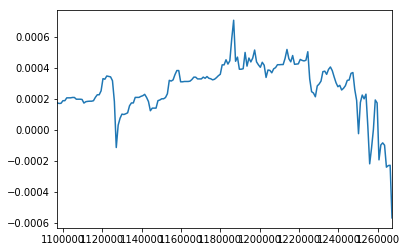

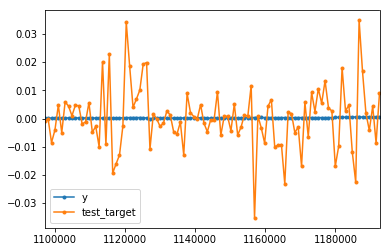

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

stock_id = 112 #val_set.id.sample().values[0]
print(stock_id)
temp = pred[pred.id == stock_id]

temp['y'].plot()

temp['test_target'] = test_target[test_target['id'] == stock_id]['y']
temp[['y', 'test_target']].iloc[:100,:].plot(marker='.')